# ODE-based models

MEmilio implements various models based on ordinary differential equations (ODEs). ODE-based models are a subclass of compartmental models in which individuals are grouped into subpopulations called compartments.
One example of an ODE-based model implemented in MEmilio is the ODE-SECIR model. This model is particularly suited for pathogens with pre- or asymptomatic infection states and when severe or critical symptoms are possible. The model assumes perfect immunity after recovery. The used infection states or compartments are Susceptible (S), Exposed(E), Non-symptomatically Infected (Ins), Symptomatically Infected (Isy), Severely Infected (Isev), Critically Infected (Icri), Dead (D) and Recovered (R).

The following example shows how to set up and run a simple ODE-SECIR model without any further stratification. The example requires to have the memilio-simulation package installed which can be accessed under https://github.com/SciCompMod/memilio/tree/main/pycode/memilio-simulation.

In [1]:
import memilio.simulation.osecir as osecir
from memilio.simulation import AgeGroup
import numpy as np

In [2]:
# Initialize total population, simulation start time, simulation time frame and initial step size
total_population = 100000
t0 = 0
tmax = 100
dt = 0.1

In [3]:
# Create a model without any further stratification i.e. with only one (sociodemographic) group

model = osecir.Model(1)

The ODE-SECIR model has various (epidemiological) parameters. A list of the parameters can be found at https://memilio.readthedocs.io/en/latest/cpp/models/osecir.html.

In [4]:
# Set infection state transition times (in days)
group = AgeGroup(0)
model.parameters.TimeExposed[group] = 3.2
model.parameters.TimeInfectedNoSymptoms[group] = 2.
model.parameters.TimeInfectedSymptoms[group] = 6.
model.parameters.TimeInfectedSevere[group] = 12.
model.parameters.TimeInfectedCritical[group] = 8.

# Set infection state transition probabilities
model.parameters.RelativeTransmissionNoSymptoms[group] = 0.67
model.parameters.TransmissionProbabilityOnContact[group] = 0.1
model.parameters.RecoveredPerInfectedNoSymptoms[group] = 0.2
model.parameters.RiskOfInfectionFromSymptomatic[group] = 0.25
model.parameters.SeverePerInfectedSymptoms[group] = 0.2
model.parameters.CriticalPerSevere[group] = 0.25
model.parameters.DeathsPerCritical[group] = 0.3

# Set contact frequency
model.parameters.ContactPatterns.cont_freq_mat[0].baseline = np.ones((1, 1)) * 10

In addition to the parameters, the initial number of individuals in each compartment has to be set. If a compartment is not set, its initial value is zero.

In [5]:
# 1% of the population is initially infected, 0.5% Exposed and 0.5% in the pre- or asymptomatic state
model.populations[group, osecir.InfectionState.Exposed] = 0.005 * total_population
model.populations[group, osecir.InfectionState.InfectedNoSymptoms] = 0.005 * total_population
# The rest of the population is Susceptible
model.populations.set_difference_from_total(
    (group, osecir.InfectionState.Susceptible), total_population)

To get reasonable results, the model needs to have plausible parameter values (e.g. state transition times > 0). These constraints can be checked and automatically corrected by the `apply_constraints` function.

In [6]:
# Apply mathematical constraints to parameters
model.apply_constraints()

False

After having initialized the model, dynamics can be simulated. The simulation output is a time series containing the evolution of all compartments over time.

In [7]:
# Simulate model from t0 to tmax with initial step size dt
result = osecir.simulate(t0, tmax, dt, model)
result.print_table()

[2026-02-03 11:46:25.093] [info] Adaptive step sizing successful to tolerances.

Time             C1               C2               C3               C4               C5               C6               C7               C8               C9               C10             
         0.00000      99000.00000        500.00000        500.00000          0.00000          0.00000          0.00000          0.00000          0.00000          0.00000          0.00000
         0.02780      98990.78367        504.85071        497.43234          0.00000          5.53378          0.00000          0.00257          0.00000          1.39693          0.00000
         0.07265      98975.93935        512.56601        493.45299          0.00000         14.34610          0.00000          0.01741          0.00001          3.67813          0.00000
         0.16456      98945.57299        527.98693        485.89708          0.00000         31.99156          0.00000          0.08816          0.00010          8.46318  

MEmilio provides the functionality to interpolate time series to full days using linear interpolation.

In [8]:
# Interpolate result to full days
interpolated_result = osecir.interpolate_simulation_result(result)
interpolated_result.print_table()


Time             C1               C2               C3               C4               C5               C6               C7               C8               C9               C10             
         0.00000      99000.00000        500.00000        500.00000          0.00000          0.00000          0.00000          0.00000          0.00000          0.00000          0.00000
         1.00000      98668.04319        650.82449        447.45350          0.00000        171.77599          0.00000          2.94709          0.02089         58.93465          0.00021
         2.00000      98313.82866        780.34235        449.50322          0.00000        309.00723          0.00000         10.57365          0.14909        136.59274          0.00305
         3.00000      97916.77116        912.33642        482.25160          0.00000        432.56789          0.00000         21.68986          0.44841        233.92075          0.01391
         4.00000      97459.77572       1058.82609        536.95

Single result time points and its values can be accessed via the `get_time` and `get_value` functions. The whole time series can be converted to an array with the first row the time points and the following rows the compartment sizes using `as_ndarray`.

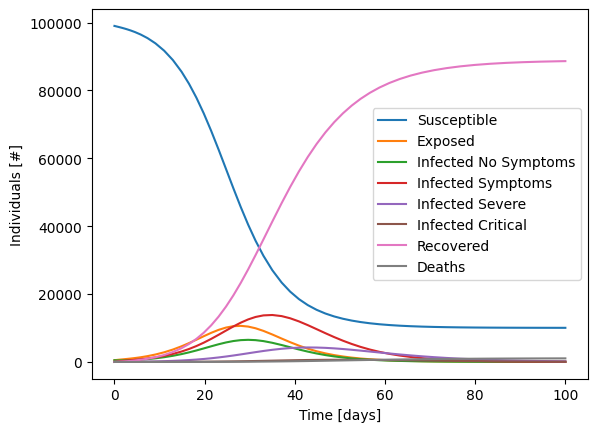

In [9]:
# Get number of time points
num_time_points = result.get_num_time_points()

# Convert time series to array
result_array = result.as_ndarray()

# Plot the number of infected with symptoms over time
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
time = result_array[0, :]
ax.plot(time, result_array[1 + int(osecir.InfectionState.Susceptible), :], label='Susceptible')
ax.plot(time, result_array[1 + int(osecir.InfectionState.Exposed), :], label='Exposed')
ax.plot(time, result_array[1 + int(osecir.InfectionState.InfectedNoSymptoms), :], label='Infected No Symptoms')
ax.plot(time, result_array[1 + int(osecir.InfectionState.InfectedSymptoms), :], label='Infected Symptoms')
ax.plot(time, result_array[1 + int(osecir.InfectionState.InfectedSevere), :], label='Infected Severe')
ax.plot(time, result_array[1 + int(osecir.InfectionState.InfectedCritical), :], label='Infected Critical')
ax.plot(time, result_array[1 + int(osecir.InfectionState.Recovered), :], label='Recovered')
ax.plot(time, result_array[1 + int(osecir.InfectionState.Dead), :], label='Deaths')
ax.set_xlabel('Time [days]')
ax.set_ylabel('Individuals [#]')
ax.legend()
plt.show()